In [2]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from PIL import Image
from itertools import cycle
from random import randint
import re, math
import seaborn as sns; sns.set_style("white")
from sklearn.manifold import TSNE
import umap.umap_ as umap
import datetime
import gc
from pathlib import Path
from cytominer_eval import evaluate
import plotly.graph_objects as go
#import plotly.offline as pyo
#import plotly.io as pio
os.getcwd()

'/scratch-shared/martin/002_24OHC-v2'

In [3]:
figformat = 'png'
dpi = 150
project = '24OHC'

In [4]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)


    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Read data

In [5]:
BaseDir = './ImageMeanFeatures/'
sorted(os.listdir(BaseDir))

['ImageMeansAllPlates_2.csv']

### Output directory

In [6]:
OutputDir = input("Enter name for output folder: ") #
if not os.path.exists(OutputDir):
    os.makedirs(OutputDir)

Enter name for output folder:  UMAP


In [7]:
df = pd.read_csv('{}/ImageMeansAllPlates_2.csv'.format(BaseDir), sep=';' , index_col=0)
df.shape

(5525, 2126)

In [8]:
df['plate'] = df.index.str[-11:-6] 
df['plate-name'] = df.index.str[:12] + 'plate' + df.index.str[-10:-6] + '-' + df.index.str[16:24]
df['well_id'] = df.index.str[-5:-2]
df['L'] = df['plate'].str[-2:]
df['plateWell'] = df['L'] + '_' + df['well_id']
df['site'] = df.index.str[-1:]


In [9]:
df.tail(1)

,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,plate,plate-name,well_id,L,plateWell,site
ImageID,,,,,,,,,,,,,,,,,,,,,
24OHC-v2-FA-T98G-48h-P1-L2_O23_9,1,206.5,9,1494.868932,2188.575243,1163.898058,1125.206311,1118.682039,1079.987864,1140.838453,...,-0.006412,-0.00417,0.188823,0.296279,P1-L2,24OHC-v2-FA-plate1-L2--48h-P1-,O23,L2,L2_O23,9


In [11]:
Layout =  pd.read_csv('24OHC_v2_layout_conc_TGFb_L1_L2.csv', sep=';')
Layout.head(1)

,plateID,new_plate_name,well,cbk_id,cpd_conc,cpd_conc_unit,DMSO_conc,DMSO_conc_unit
0,L1,24OHC2-v1-plate1-L1,B03,[berb],10.0,uM,0.1,perc


In [12]:
Layout['plateWell']= Layout['plateID'] + '_' + Layout['well']
Layout.tail(1)

,plateID,new_plate_name,well,cbk_id,cpd_conc,cpd_conc_unit,DMSO_conc,DMSO_conc_unit,plateWell
599,L2,24OHC2-v1-plate1-L2,O13,TGFb,5.0,ng,0.0,perc,L2_O13


In [13]:
compoundDict = dict(zip(Layout.plateWell, Layout.cbk_id))
concentrationDict = dict(zip(Layout.plateWell, Layout.cpd_conc))

In [14]:
labels = ['compound', 'concentration']
for a in labels:
    df[a] = df['plateWell'].map(eval('{}Dict'.format(a)))

In [15]:
df.shape

(5525, 2134)

In [16]:
df.dropna(subset = ['compound'], inplace=True)
df.reset_index(drop=False, inplace=True)
df.tail(3)

,ImageID,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,plate,plate-name,well_id,L,plateWell,site,compound,concentration
5378,24OHC-v2-FA-T98G-48h-P1-L2_O23_7,1,220.0,7,1530.161731,2231.264237,1052.765376,1132.706150,1007.571754,1086.692483,...,0.062410,-0.096806,P1-L2,24OHC-v2-FA-plate1-L2--48h-P1-,O23,L2,L2_O23,7,[buffer],0.1
5379,24OHC-v2-FA-T98G-48h-P1-L2_O23_8,1,280.5,8,1393.194643,2046.066071,1145.982143,1129.376786,1102.316071,1085.758929,...,0.064724,-0.107943,P1-L2,24OHC-v2-FA-plate1-L2--48h-P1-,O23,L2,L2_O23,8,[buffer],0.1
5380,24OHC-v2-FA-T98G-48h-P1-L2_O23_9,1,206.5,9,1494.868932,2188.575243,1163.898058,1125.206311,1118.682039,1079.987864,...,0.188823,0.296279,P1-L2,24OHC-v2-FA-plate1-L2--48h-P1-,O23,L2,L2_O23,9,[buffer],0.1


In [17]:
CompoundList = sorted(list(set(df['compound'])))
CompoundList[:]

['24OHC',
 'TGFb',
 '[berb]',
 '[buffer]',
 '[ca-0]',
 '[cycl]',
 '[dmso]',
 '[etop]',
 '[fenb]',
 '[flup]',
 '[iono]',
 '[meto]',
 '[repa]',
 '[sorb]',
 '[stau]',
 '[tetr]']

In [18]:
PlateList = sorted(list(set(df['plate'])))
PlateList

['P1-L1', 'P1-L2']

### QC


In [19]:
QC =  pd.read_csv('./QC/3SD/3SD_Flags.csv', sep=';', index_col=[0]) # ./QC/5SD/5SD_Flags.csv
QC['ImageID'] = QC['Metadata_Barcode'] + '_' + QC['Metadata_Well'] + '_'  + QC['Metadata_Site'].astype(str)
QC.head(3)

,Metadata_Barcode,Metadata_Well,Metadata_Site,Count_nuclei,ImageQuality_FocusScore_CONC,ImageQuality_FocusScore_HOECHST,ImageQuality_FocusScore_MITO,ImageQuality_FocusScore_PHAandWGA,ImageQuality_FocusScore_SYTO,OutlierScaled_FocusScore_-inf_inf,Outlier_FocusScore_-inf_0.2,OutlierScaled_FocusScore_-4_4,OutlierScaled_MaxIntensity_-4_4,OutlierScaled_MeanIntensity_-4_4,OutlierScaled_PowerLogLogSlope_-4_4,OutlierScaled_StdIntensity_-4_4,Total,ImageID
0,24OHC-v2-FA-T98G-48h-P1-L1,B02,1,210.0,0.078919,0.027422,0.014748,0.040859,0.110764,0,0,0,0,0,0,0,0,24OHC-v2-FA-T98G-48h-P1-L1_B02_1
1,24OHC-v2-FA-T98G-48h-P1-L1,B02,2,284.0,0.066023,0.027250,0.012170,0.035989,0.096229,0,0,0,0,0,0,0,0,24OHC-v2-FA-T98G-48h-P1-L1_B02_2
2,24OHC-v2-FA-T98G-48h-P1-L1,B02,3,343.0,0.078561,0.032139,0.016136,0.047762,0.120503,0,0,0,0,0,0,0,0,24OHC-v2-FA-T98G-48h-P1-L1_B02_3


In [20]:
df = df.merge(QC, left_on = 'ImageID', right_on = 'ImageID', how = 'left')

df = df[df['Total'] == 0 ] 
df.shape

(5065, 2152)

In [21]:
df.reset_index(drop=True, inplace=True)
df['WellID'] =df['ImageID'].str[:-1]
df.tail(2)

,ImageID,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,...,ImageQuality_FocusScore_SYTO,OutlierScaled_FocusScore_-inf_inf,Outlier_FocusScore_-inf_0.2,OutlierScaled_FocusScore_-4_4,OutlierScaled_MaxIntensity_-4_4,OutlierScaled_MeanIntensity_-4_4,OutlierScaled_PowerLogLogSlope_-4_4,OutlierScaled_StdIntensity_-4_4,Total,WellID
5063,24OHC-v2-FA-T98G-48h-P1-L2_O23_7,1,220.0,7,1530.161731,2231.264237,1052.765376,1132.706150,1007.571754,1086.692483,...,0.083353,0,0,0,0,0,0,0,0,24OHC-v2-FA-T98G-48h-P1-L2_O23_
5064,24OHC-v2-FA-T98G-48h-P1-L2_O23_8,1,280.5,8,1393.194643,2046.066071,1145.982143,1129.376786,1102.316071,1085.758929,...,0.079575,0,0,0,0,0,0,0,0,24OHC-v2-FA-T98G-48h-P1-L2_O23_


In [22]:
df['comp_conc'] = df['compound'] + '_' + df['concentration'].astype(str)
df['comp_conc_replicate'] = df['comp_conc'] + '_' + df['plateWell'] + '_' + df['site'].astype(str)

In [23]:
CompoundList


['24OHC',
 'TGFb',
 '[berb]',
 '[buffer]',
 '[ca-0]',
 '[cycl]',
 '[dmso]',
 '[etop]',
 '[fenb]',
 '[flup]',
 '[iono]',
 '[meto]',
 '[repa]',
 '[sorb]',
 '[stau]',
 '[tetr]']

In [24]:
numeric_columns = list()
for a in df.columns:
    if (df.dtypes[a] == 'float64') | (df.dtypes[a] == 'int64') :
        numeric_columns.append(a)
print('Found {} numeric columns'.format(len(numeric_columns)))

Found 2142 numeric columns


In [25]:
feature_columns = [fc for fc in numeric_columns if ('Metadata' not in fc) & ('Number' not in fc) &
                   ('Outlier' not in fc)  & ('ImageQuality' not in fc)  & ('concentration' not in fc)  & ('Total' not in fc)]
print('Excluded columns that are "Metadata", etc.: {}'.format(len(feature_columns)))
X = df.loc[:, feature_columns]
X.dropna(axis=1, inplace=True)
print('Removed features with missing values: {}'.format(X.shape[1]))
X = X.loc[:, (X.std() > 0.0001) ]
print('Excluded features with SD < 0.0001 : {}'.format(X.shape[1]))

varying_features = list(X.columns)
#X['ImageID'] = df['ImageID']
#X.tail(1)

Excluded columns that are "Metadata", etc.: 2106
Removed features with missing values: 704
Excluded features with SD < 0.0001 : 645


In [26]:
dfDMSO = df[df['compound'] == '[dmso]']  # Calculate median values for DMSO
dfDMSO_Medians = dfDMSO[varying_features].median()

In [27]:
dfDMSO_MADs = (dfDMSO[varying_features] - dfDMSO[varying_features].median()).abs().median() # Calculate median absolute deviations for DMSO

In [28]:
print(len(varying_features))
varying_in_DMSO = dfDMSO_MADs.loc[dfDMSO_MADs > 0.0001].index # Remove features that are invariant or close to invariant in DMSO
len(varying_in_DMSO)

645


562

In [29]:
dfZscores = df[varying_in_DMSO].copy()  # Calculate z-scores
dfZscores = (df[varying_in_DMSO] - dfDMSO_Medians[varying_in_DMSO])/dfDMSO_MADs[varying_in_DMSO]
dfZscores.clip(lower=-10, upper=10,  inplace=True) # Clip extreme values

dfZscores = dfZscores.merge(df[['compound', 'concentration', 'plate', 'well_id', 'site', 'comp_conc',
       'comp_conc_replicate' ]], left_index=True, right_index=True) 
dfZscores.tail(5)

,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_7_nuclei,RadialDistribution_ZernikePhase_illumSYTO_9_9_nuclei,Count_nuclei,compound,concentration,plate,well_id,site,comp_conc,comp_conc_replicate
5060,-0.597564,-0.881845,-2.333829,0.790215,-2.256308,0.795198,-2.290398,0.778518,-2.181802,-0.879116,...,2.213563,0.596185,-1.200,[buffer],0.1,P1-L2,O23,4,[buffer]_0.1,[buffer]_0.1_L2_O23_4
5061,1.238304,1.298187,-1.455296,1.544669,-1.445085,1.514177,-1.446833,1.509140,1.348275,1.165880,...,0.800656,-0.028253,0.350,[buffer],0.1,P1-L2,O23,5,[buffer]_0.1,[buffer]_0.1_L2_O23_5
5062,-0.067249,-0.120759,-1.067884,-0.600248,-1.044613,-0.593887,-1.053548,-0.602918,-0.300910,-0.082402,...,-0.675004,-0.649490,0.275,[buffer],0.1,P1-L2,O23,6,[buffer]_0.1,[buffer]_0.1_L2_O23_6
5063,0.826090,0.543729,-0.613855,1.051555,-0.599661,1.035191,-0.607009,1.030304,-0.323942,0.611242,...,-0.155097,1.039505,0.225,[buffer],0.1,P1-L2,O23,7,[buffer]_0.1,[buffer]_0.1_L2_O23_7
5064,-1.822113,-1.749213,1.207322,0.980887,1.211430,1.015455,1.202709,0.984556,-0.475637,-1.875405,...,0.517973,1.974107,2.450,[buffer],0.1,P1-L2,O23,8,[buffer]_0.1,[buffer]_0.1_L2_O23_8


In [30]:
dfZscores.columns[-10:]

Index(['RadialDistribution_ZernikePhase_illumSYTO_9_7_nuclei',
       'RadialDistribution_ZernikePhase_illumSYTO_9_9_nuclei', 'Count_nuclei',
       'compound', 'concentration', 'plate', 'well_id', 'site', 'comp_conc',
       'comp_conc_replicate'],
      dtype='object')

### PCA Make sure to have enough of colors specified in the palette if statements!

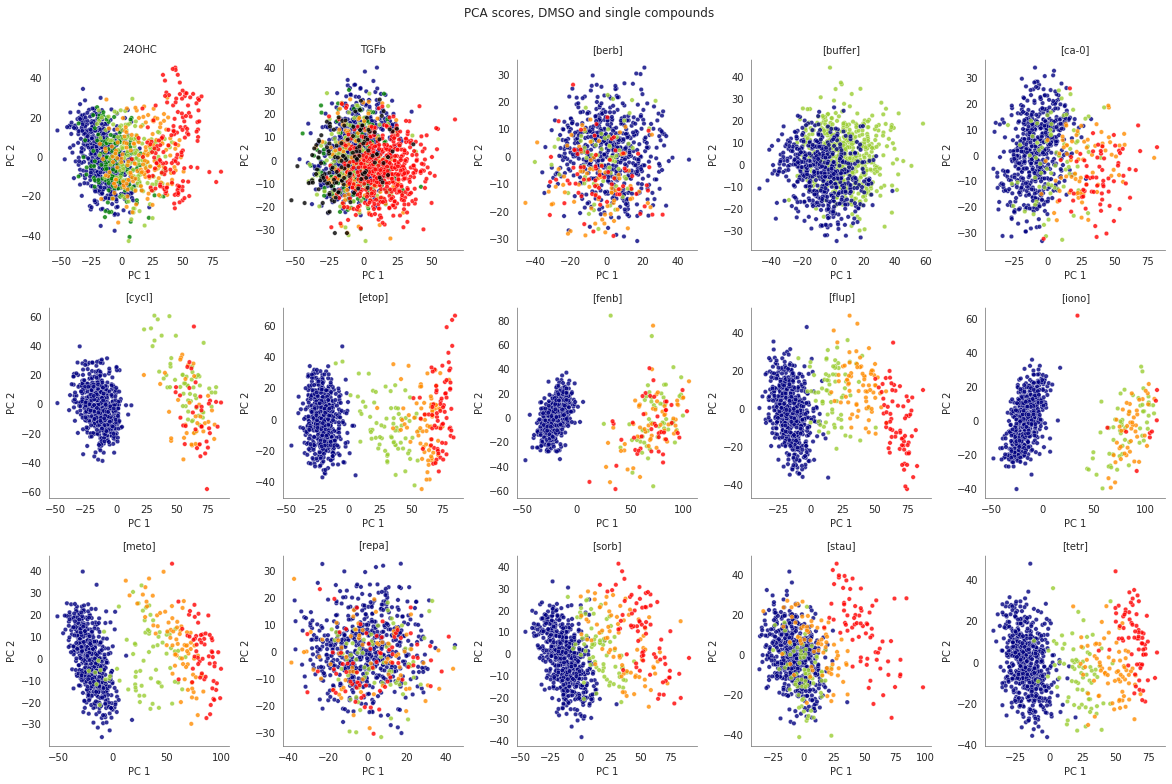

In [31]:
fig = plt.figure(figsize = (20,12))
sp = 1
for comp in (CompoundList[0:6] + CompoundList[7:]):
    #for plate in PlateList:
        # fOneCompound = df.loc[(df['compound'] == comp), ['compound','plate' ] + varying_features]
        dfOneCompound = dfZscores.loc[dfZscores['compound'] == comp]
        dfDMSO = dfZscores.loc[dfZscores['compound'] == '[dmso]']
        frames = [dfDMSO, dfOneCompound]
        dfOneCompoundandDMSO = pd.concat(frames)
        #dfOneCompoundandDMSO['plate_comp_conc'] = dfOneCompoundandDMSO['plate'] +'_' + dfOneCompoundandDMSO['compound'] +'_' + dfOneCompoundandDMSO['concentration'].astype(str)
        #dfOneCompoundandDMSO.sort_values(by = ['plate', 'compound', 'concentration'], inplace = True)
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        #PlateCompConcList = list(dict.fromkeys(list(dfOneCompoundandDMSO['plate_comp_conc'])))
        
        nr_colors = len(set(dfOneCompoundandDMSO['comp_conc']))
        if nr_colors == 4:
            colors = ['navy', 'yellowgreen', 'darkorange', 'red']
        if nr_colors == 6:
            colors = ['navy', 'green','yellowgreen', 'darkorange', 'red', "black"] 
        if nr_colors == 5:
            colors = ['navy', 'green','yellowgreen', 'darkorange', 'red'] 
        if nr_colors == 3:
            colors = ['navy', 'yellowgreen', 'darkorange']
        if nr_colors == 2:
            colors = [ 'yellowgreen', 'navy']        
        x = dfOneCompoundandDMSO.loc[:, varying_in_DMSO].values
        pca = PCA(n_components=50)
        #x = StandardScaler().fit_transform(x)
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)
        principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
        principalDf = principalDf.merge(dfOneCompoundandDMSO[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
        principalDf.sort_values(by = [ 'concentration', 'compound'], inplace = True)
        # principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')
        
        
        ax = fig.add_subplot(3, 5, sp) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        x
        ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='comp_conc', data=principalDf, palette=colors,  s=20, alpha = 0.8,  marker = 'o');
        ax.set_title('{}'.format(comp), fontsize = 10)
        ax.get_legend().remove()

        ax.set_facecolor('w')
        sp += 1
plt.subplots_adjust(top =0.92, wspace=0.3, hspace=0.3)
fig.suptitle('PCA scores, DMSO and single compounds'.format(comp), fontsize = 12)
fig.savefig('{}/PCA.{}'.format(OutputDir, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PCA.{}'.format(OutputDir, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

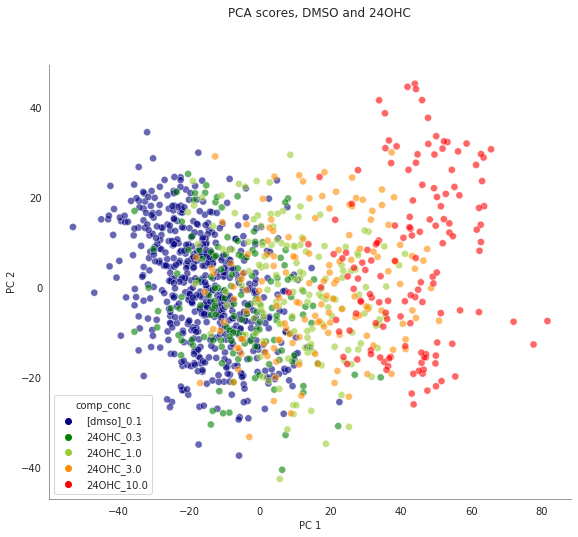

In [32]:
fig = plt.figure(figsize = (10,8))
sp = 1
for comp in (CompoundList[:1]):
    #for plate in PlateList:
        # fOneCompound = df.loc[(df['compound'] == comp), ['compound','plate' ] + varying_features]
        dfOneCompound = dfZscores.loc[dfZscores['compound'] == comp]
        dfDMSO = dfZscores.loc[dfZscores['compound'] == '[dmso]']
        frames = [dfDMSO, dfOneCompound]
        dfOneCompoundandDMSO = pd.concat(frames)
        #dfOneCompoundandDMSO['plate_comp_conc'] = dfOneCompoundandDMSO['plate'] +'_' + dfOneCompoundandDMSO['compound'] +'_' + dfOneCompoundandDMSO['concentration'].astype(str)
        #dfOneCompoundandDMSO.sort_values(by = ['plate', 'compound', 'concentration'], inplace = True)
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        #PlateCompConcList = list(dict.fromkeys(list(dfOneCompoundandDMSO['plate_comp_conc'])))

 
        x = dfOneCompoundandDMSO.loc[:, varying_in_DMSO].values
        pca = PCA(n_components=100)
        #x = StandardScaler().fit_transform(x)
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)
        principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
        principalDf = principalDf.merge(dfOneCompoundandDMSO[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
        principalDf.sort_values(by = [ 'concentration'], inplace = True)
        principalDf.reset_index(drop=True, inplace = True) 
        principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')
        
        
        ax = fig.add_subplot(1, 1, sp) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red']
        ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='comp_conc', data=principalDf, palette=colors,  s=50, alpha = 0.6,  marker = 'o');
        
        

        ax.set_facecolor('w')
        sp += 1
plt.subplots_adjust( wspace=0.3, right = 0.85)
fig.suptitle('PCA scores, DMSO and {}'.format(comp), fontsize = 12)
fig.savefig('{}/PCA_DMSOand{}.{}'.format(OutputDir,  comp, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PCA_DMSOand{}.{}'.format(OutputDir,  comp, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

[0 0 0 ... 1 1 1]
[[-1.37350822]
 [-1.37350822]
 [-1.37350822]
 ...
 [ 0.72806263]
 [ 0.72806263]
 [ 0.72806263]]
[-4.81517832e+31 -8.88678586e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


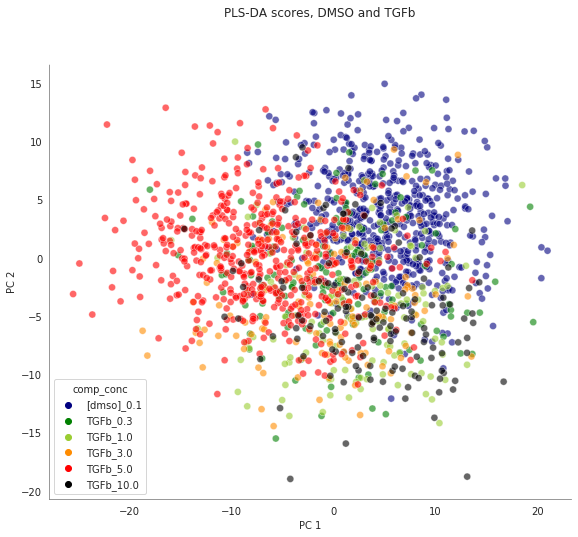

In [33]:
fig = plt.figure(figsize = (10,8))
sp = 1
for comp in (CompoundList[1:2]):
    #for plate in PlateList:
        # fOneCompound = df.loc[(df['compound'] == comp), ['compound','plate' ] + varying_features]
        dfOneCompound = dfZscores.loc[(dfZscores['compound'] == comp) & (dfZscores['concentration'] != 'Placeholder')]
        dfDMSO = dfZscores.loc[dfZscores['compound'] == '[dmso]']
        frames = [dfDMSO, dfOneCompound]
        dfOneCompoundandDMSO = pd.concat(frames)
        #dfOneCompoundandDMSO['plate_comp_conc'] = dfOneCompoundandDMSO['plate'] +'_' + dfOneCompoundandDMSO['compound'] +'_' + dfOneCompoundandDMSO['concentration'].astype(str)
        #dfOneCompoundandDMSO.sort_values(by = ['plate', 'compound', 'concentration'], inplace = True)
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        #PlateCompConcList = list(dict.fromkeys(list(dfOneCompoundandDMSO['plate_comp_conc'])))

 
        x = dfOneCompoundandDMSO.loc[:, varying_in_DMSO].values
        dfOneCompoundandDMSO['class'] = np.where(dfOneCompoundandDMSO['compound'] == '[dmso]', 0, 1)
        y = dfOneCompoundandDMSO.loc[:, 'class'].values
        x = StandardScaler(with_mean=True, with_std=False).fit_transform(x)
        #y = dfOneCompoundandDMSO.loc[:, 'concentration'].values
        print(y)
        y = StandardScaler().fit_transform(y.reshape(-1, 1))
        print(y)
        pls2 = PLSRegression(n_components=2)
        pls2.fit(x, y)
        Q2 = cross_val_score(pls2, x, y, cv=5, scoring='r2')
        print(Q2)
        scores = pls2.x_scores_
        scoreDf = pd.DataFrame(data = scores) #, columns = ['comp1', 'comp2', 'comp3'])
        scoreDf.rename(columns={0: 'comp1', 1: 'comp2'}, inplace=True)        
        
        scoreDf = scoreDf.merge(dfOneCompoundandDMSO[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
        scoreDf.sort_values(by = [ 'concentration'], inplace = True)
        scoreDf.reset_index(drop=True, inplace = True) 
        scoreDf.to_csv('{}/PLS_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')
        
        
        
        ax = fig.add_subplot(1, 1, sp) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red', 'black']
        # colors = ['navy','red']
        ax =sns.scatterplot(x='comp1', y='comp2',  
                          hue='comp_conc', data=scoreDf, palette=colors,  s=50, alpha = 0.6,  marker = 'o');
        
        

        ax.set_facecolor('w')
        sp += 1
plt.subplots_adjust( wspace=0.3, right = 0.85)
fig.suptitle('PLS-DA scores, DMSO and {}'.format(comp), fontsize = 12)
fig.savefig('{}/PLSDA_DMSOand{}.{}'.format(OutputDir,  comp, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PLSDA_DMSOand{}.{}'.format(OutputDir,  comp, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

### Umap

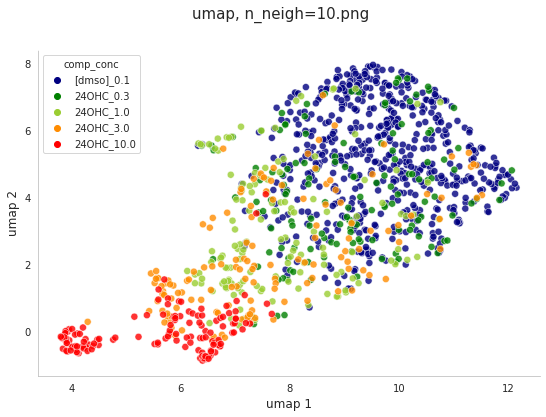

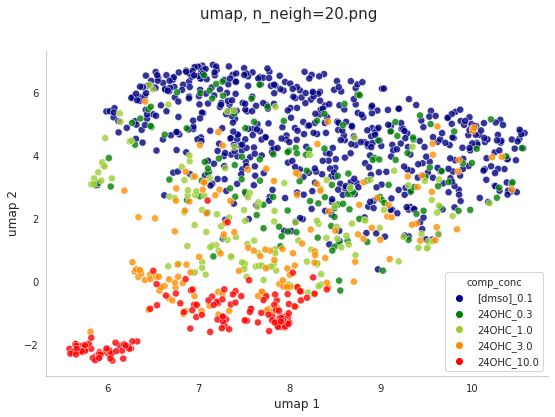

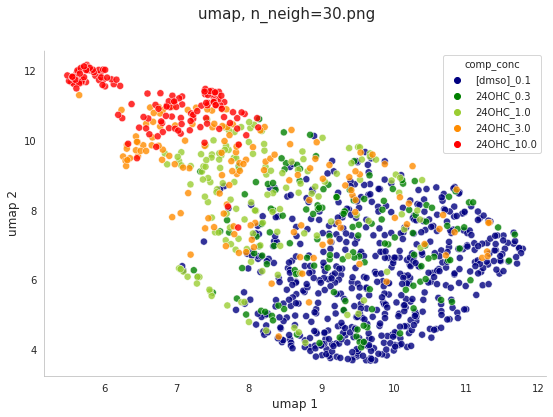

In [34]:
for n_neighbors in range(10, 31, 10):      
            reducer = umap.UMAP(n_neighbors = n_neighbors)
            embedding = reducer.fit_transform(principalDf.iloc[:,:50] )
            umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
            umap_resultDf = pd.concat([umap_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            umap_resultDf.sort_values(by = [ 'concentration'], inplace = True)
            umap_resultDf.to_csv('{}/umap.csv'.format(OutputDir), sep=';')

            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('umap 1', fontsize = 12)
            ax.set_ylabel('umap 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')
            colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red']
            ax =sns.scatterplot(x='umap 1', y='umap 2',  
                          hue='comp_conc', data=umap_resultDf, palette=colors,  s=50, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

                                       
            """for target, color in zip(targets,colors):
                            indicesToKeep = umap_resultDf['compound'] == target
                            ax.scatter(umap_resultDf.loc[indicesToKeep, 'umap 1']
                                       , umap_resultDf.loc[indicesToKeep, 'umap 2']
                                       , c = color
                                       , edgecolors= None
                                       , alpha = 0.3
                                       , marker ='o'
                                       , s = 20
                                       )
            fig.legend(targets, fontsize = 9, loc="upper right", frameon=False)"""

            fig.suptitle('umap, n_neigh={}.png'.format(n_neighbors), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  
            fig.savefig('{}/Umap_DMSOand_{}_nneighb_{}.{}'.format(OutputDir,  comp, n_neighbors, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()

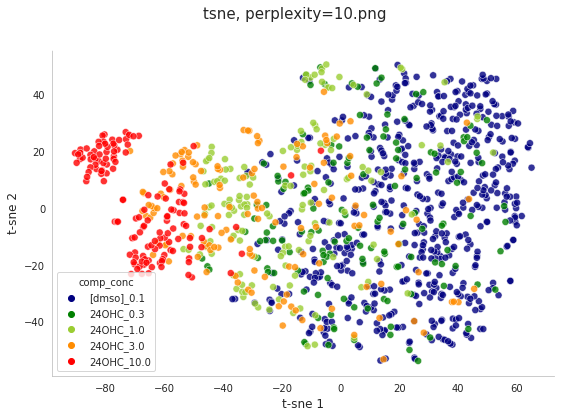

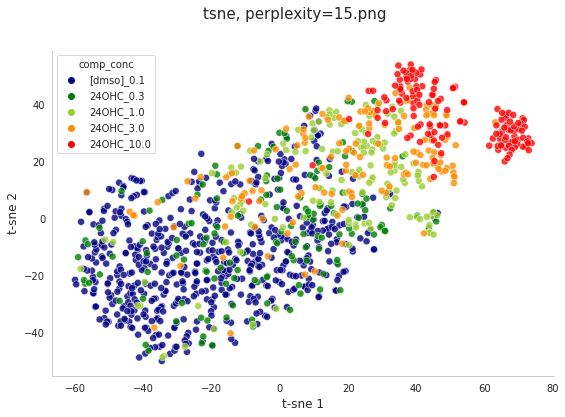

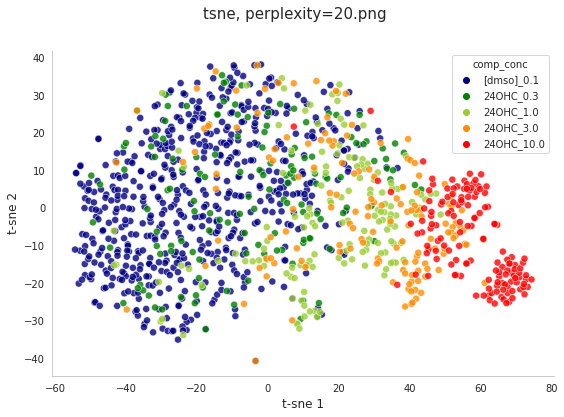

In [35]:
for perpl in range(10, 21, 5):
            x = principalDf.iloc[:, :50].values
            X_embedded = TSNE(n_components=2, perplexity=perpl).fit_transform(x)
            tsne_result = pd.DataFrame(data = X_embedded, columns=["tsne 1", "tsne 2"])
            tsne_resultDf = pd.concat([tsne_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            tsne_resultDf.sort_values(by = [ 'concentration'], inplace = True)
            tsne_resultDf.to_csv('{}/tsne.csv'.format(OutputDir), sep=';')

            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('t-sne 1', fontsize = 12)
            ax.set_ylabel('t-sne 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')
            colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red']
            ax =sns.scatterplot(x='tsne 1', y='tsne 2',  
                          hue='comp_conc', data=tsne_resultDf, palette=colors,  s=50, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

                                       
            """for target, color in zip(targets,colors):
                            indicesToKeep = umap_resultDf['compound'] == target
                            ax.scatter(umap_resultDf.loc[indicesToKeep, 'umap 1']
                                       , umap_resultDf.loc[indicesToKeep, 'umap 2']
                                       , c = color
                                       , edgecolors= None
                                       , alpha = 0.3
                                       , marker ='o'
                                       , s = 20
                                       )
            fig.legend(targets, fontsize = 9, loc="upper right", frameon=False)"""

            fig.suptitle('tsne, perplexity={}.png'.format(perpl), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  
            fig.savefig('{}/Tsne_DMSOand_{}_perpl_{}.{}'.format(OutputDir,  comp, perpl, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()

In [36]:
print(sorted(list(set(df.comp_conc))))

['24OHC_0.3', '24OHC_1.0', '24OHC_10.0', '24OHC_3.0', 'TGFb_0.3', 'TGFb_1.0', 'TGFb_10.0', 'TGFb_3.0', 'TGFb_5.0', '[berb]_10.0', '[berb]_3.0', '[berb]_5.0', '[buffer]_0.1', '[ca-0]_10.0', '[ca-0]_3.0', '[ca-0]_5.0', '[cycl]_10.0', '[cycl]_3.0', '[cycl]_5.0', '[dmso]_0.1', '[etop]_10.0', '[etop]_3.0', '[etop]_5.0', '[fenb]_10.0', '[fenb]_3.0', '[fenb]_5.0', '[flup]_10.0', '[flup]_3.0', '[flup]_5.0', '[iono]_10.0', '[iono]_3.0', '[iono]_5.0', '[meto]_10.0', '[meto]_3.0', '[meto]_5.0', '[repa]_10.0', '[repa]_3.0', '[repa]_5.0', '[sorb]_10.0', '[sorb]_3.0', '[sorb]_5.0', '[stau]_10.0', '[stau]_3.0', '[stau]_5.0', '[tetr]_10.0', '[tetr]_3.0', '[tetr]_5.0']


In [37]:
SelectedCompConc = ['24OHC_10.0',  'TGFb_10.0', '[ca-0]_10.0',
                   '[cycl]_3.0', '[dmso]_0.1',  '[etop]_10.0', 
                  '[fenb]_3.0', '[fenb]_5.0', '[fenb]_10.0', '[fenb]_10.0',  '[flup]_10.0', '[iono]_3.0',
                 '[stau]_10.0',  '[tetr]_10.0' ]

In [38]:
colors = ['red', 'magenta',  'yellow', 'steelblue', 'grey',
                       'blue', 'orange', 'lime',  'yellowgreen', 'teal',
                      'lightseagreen',
           'dodgerblue',  'slateblue', 'grey', 'green', 'pink', 'red', 'red', 'deeppink', 'orangered','salmon']
  

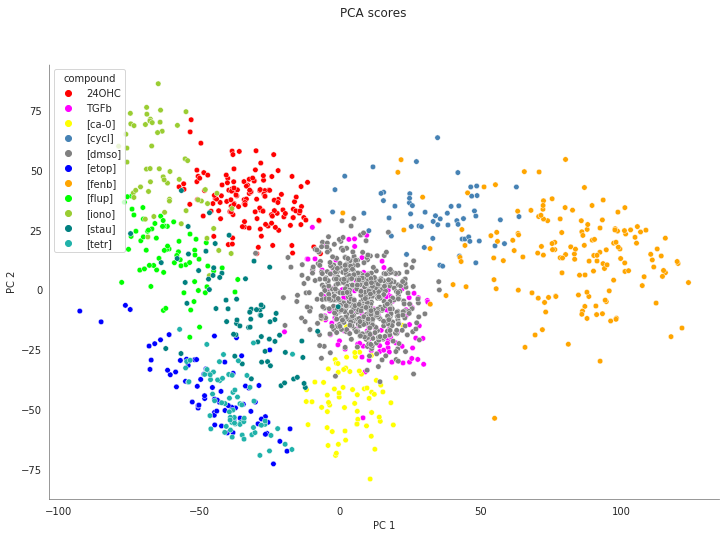

In [39]:
fig = plt.figure(figsize = (12,8))

dfSelectedCompConc = dfZscores.loc[dfZscores['comp_conc'].isin(SelectedCompConc)]
dfSelectedCompConc.reset_index(inplace=True, drop=True)
 
x = dfSelectedCompConc.loc[:, varying_in_DMSO].values
pca = PCA(n_components=50)
#x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
principalDf = principalDf.merge(dfSelectedCompConc[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
principalDf.sort_values(by = [ 'compound', 'concentration'], inplace = True)
principalDf.reset_index(drop=True, inplace = True)  

nr_colors = len(set(principalDf.compound))
colors = colors[:nr_colors]

ax = fig.add_subplot(111) 
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='compound', data=principalDf, palette=colors,  s=30, alpha = 1,  marker = 'o');

ax.set_facecolor('w')

fig.suptitle('PCA scores'.format(), fontsize = 12)
fig.savefig('{}/PCA_{}_some_compounds.{}'.format(OutputDir, project, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PCA_{}_some_compounds.{}'.format(OutputDir,  project, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

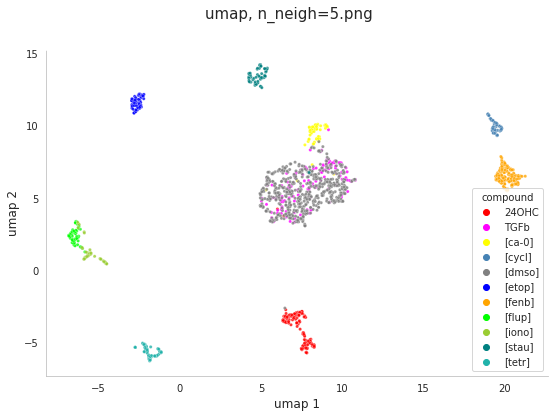

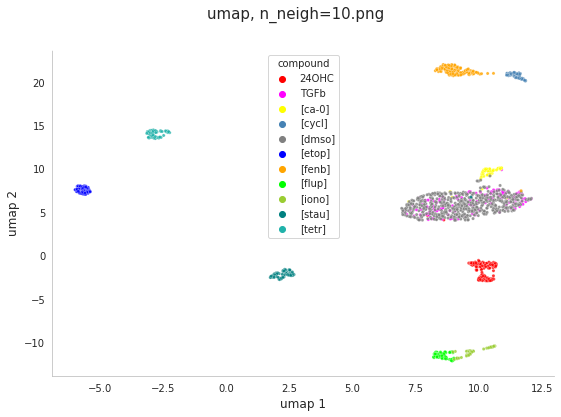

In [40]:
for n_neighbors in range(5, 11, 5):      
            reducer = umap.UMAP(n_neighbors = n_neighbors)
            embedding = reducer.fit_transform(principalDf.iloc[:,:20] )
            umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
            umap_resultDf = pd.concat([umap_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            umap_resultDf.sort_values(by = ['compound',  'concentration'], inplace = True)
            umap_resultDf.to_csv('{}/umap.csv'.format(OutputDir), sep=';')
           
            nr_colors = len(set(umap_resultDf.compound))
            colors = colors[:nr_colors]
            
            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('umap 1', fontsize = 12)
            ax.set_ylabel('umap 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')

            ax =sns.scatterplot(x='umap 1', y='umap 2',  
                          hue='compound', data=umap_resultDf, palette=colors,  s=10, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

                                       
            """for target, color in zip(targets,colors):
                            indicesToKeep = umap_resultDf['compound'] == target
                            ax.scatter(umap_resultDf.loc[indicesToKeep, 'umap 1']
                                       , umap_resultDf.loc[indicesToKeep, 'umap 2']
                                       , c = color
                                       , edgecolors= None
                                       , alpha = 0.3
                                       , marker ='o'
                                       , s = 20
                                       )
            fig.legend(targets, fontsize = 9, loc="upper right", frameon=False)"""

            fig.suptitle('umap, n_neigh={}.png'.format(n_neighbors), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  
            fig.savefig('{}/Umap_{}__some_compounds_nneighb_{}.{}'.format(OutputDir,  project, n_neighbors, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()

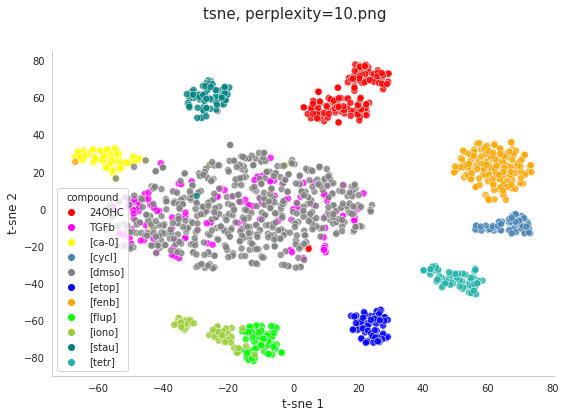

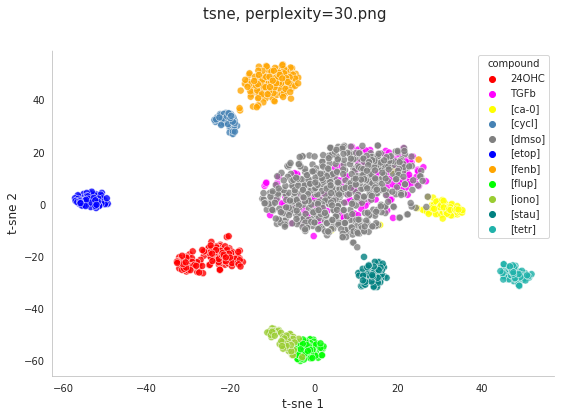

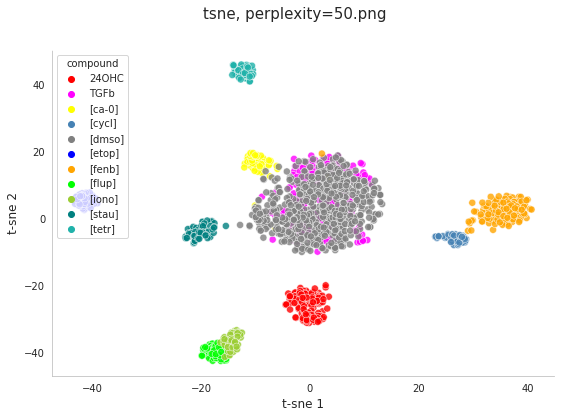

In [41]:
for perpl in range(10, 51, 20):
            x = principalDf.iloc[:, :50].values
            X_embedded = TSNE(n_components=2, perplexity=perpl).fit_transform(x)
            tsne_result = pd.DataFrame(data = X_embedded, columns=["tsne 1", "tsne 2"])
            tsne_resultDf = pd.concat([tsne_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            tsne_resultDf.sort_values(by = ['compound', 'concentration'], inplace = True)
            tsne_resultDf.to_csv('{}/tsne.csv'.format(OutputDir), sep=';')
            
            nr_colors = len(set(tsne_resultDf.compound))
            colors = colors[:nr_colors]

            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('t-sne 1', fontsize = 12)
            ax.set_ylabel('t-sne 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')

            ax =sns.scatterplot(x='tsne 1', y='tsne 2',  
                          hue='compound', data=tsne_resultDf, palette=colors,  s=50, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

            fig.suptitle('tsne, perplexity={}.png'.format(perpl), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  

            fig.savefig('{}/Tsne_{}__some_compounds_perpl_{}.{}'.format(OutputDir,  project, perpl, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()